In [1]:
%matplotlib inline

from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

from frameworks.scipy.dtw import dtw
from frameworks.scipy.mfcc import freq_to_mel, get_filterbank, mfsc
from frameworks.scipy.windows import get_windows
from SLPDL_utils.dtw_dataset import DTW_Dataset, DTW_MFCC_Dataset, build_dtw_collate


In [2]:
import warnings
from numba.core.errors import NumbaWarning
warnings.simplefilter("ignore", category=NumbaWarning)

In [3]:
free10x4x4_list = './data_lists/free10x4x4.csv'
free10x4x4 = DTW_Dataset(free10x4x4_list, data_root='', names=None, type_='train')
free10x4x4_mfcc = DTW_MFCC_Dataset(free10x4x4, mfsc_funct=None, return_wav=True)

free10x4x4_loader = DataLoader(free10x4x4_mfcc, collate_fn=build_dtw_collate(use_torch=False, device=None, text_labels=None, speaker_labels=None), batch_size=1)

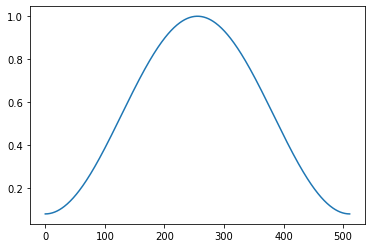

In [4]:
plt.plot(get_windows(512, type_='hamming'))

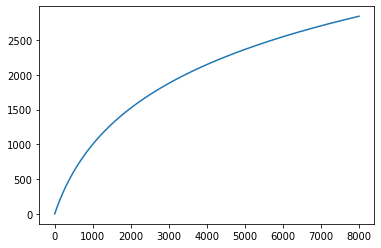

In [5]:
plt.plot(freq_to_mel(np.arange(8000)))

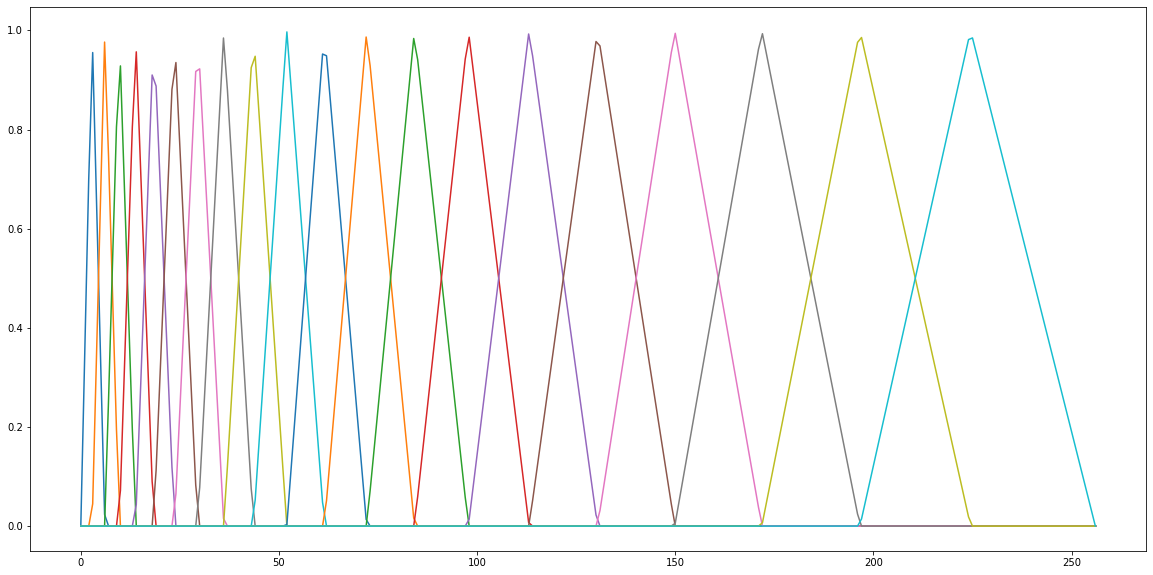

In [6]:
H = get_filterbank(numfilters=20, filterLen=257, lowFreq=0, highFreq=8000, samplingFreq=16000)

fig = plt.figure(figsize=(20,10))

for h in H:
  plt.plot(h)

In [7]:
Audio(filename=free10x4x4[0][2], autoplay=True)

./data/dtw3/free-spoken-digit-dataset/recordings/9_theo_3.wav Sampling frequency:  8000
./data/dtw3/free-spoken-digit-dataset/recordings/9_nicolas_1.wav Sampling frequency:  8000


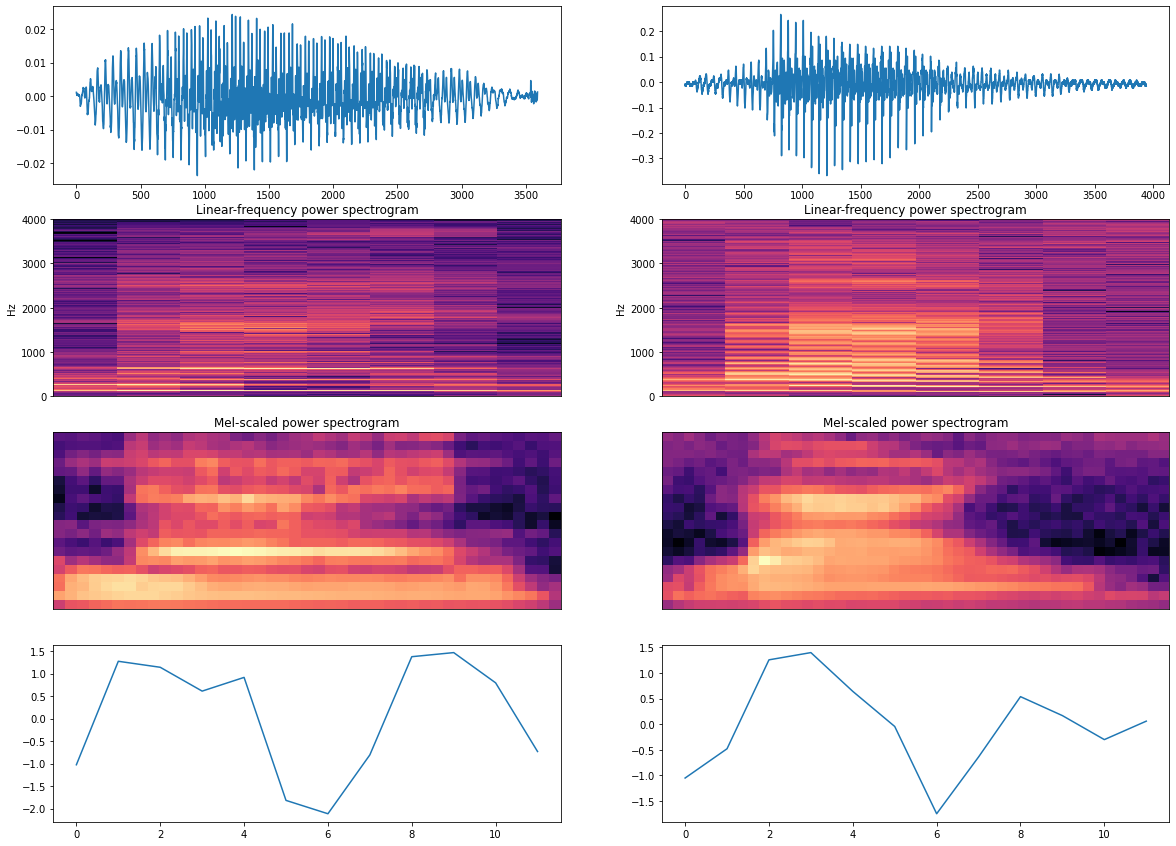

In [8]:
fig = plt.figure(figsize=(20,15))

for i, data in enumerate(free10x4x4_loader):
    if i >= 2 : break
    
    M, y, sfr, wav, text, speaker = tuple(zip(*data))[0]
    
    print(wav, 'Sampling frequency: ', sfr)
    
    fig = plt.subplot(4, 2, i+1)
    plt.plot(y)

    # Liner frequency spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig = plt.subplot(4, 2, i+3)
    
    librosa.display.specshow(D, y_axis='linear', sr=sfr)
    plt.title('Linear-frequency power spectrogram')

    # Mel-scaled spectrogram (20 bank filters)
    S = mfsc(y, sfr)
    fig = plt.subplot(4, 2, i+5)
    librosa.display.specshow(S - S.min())
    plt.title('Mel-scaled power spectrogram')

    # MFCC(5)
    fig = plt.subplot(4, 2, i+7)
    plt.plot(M[1,:])


In [9]:
a = np.array([1,4,4,5,9,3,1,8,8], dtype=np.float32)[:, np.newaxis]
b = np.array([1,2,3,8,8,3,1,8], dtype=np.float32)[:, np.newaxis]
dist, path = dtw(a, b, metric='sqeuclidean')
print(dist)

0.0


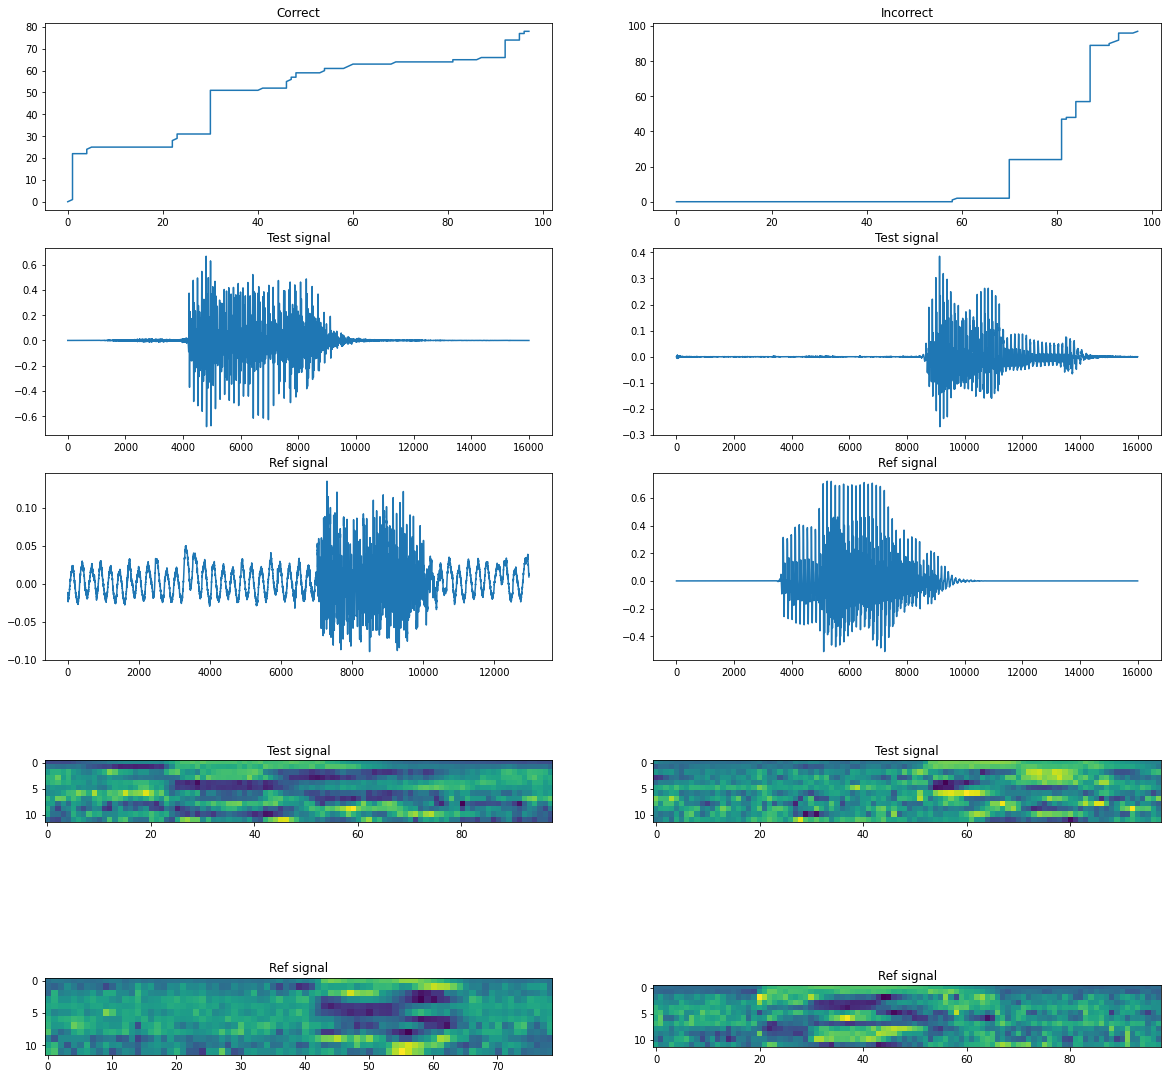

In [30]:
# TODO: Plot one example of the alignment with the closest reference when the test signal is different from the reference signal (different digit) or equal (same digit).
fig = plt.figure(figsize=(20, 20))

commands10x10_list = './data_lists/commands10x10.csv'
commands10x10 = DTW_Dataset(commands10x10_list, data_root='', names=None, type_='train')
commands10x10_mfcc = DTW_MFCC_Dataset(commands10x10, return_wav=True)
commands10x10_loader = DataLoader(commands10x10_mfcc, collate_fn=build_dtw_collate(), batch_size=1)

z = (1 | 2)
for i, test_data in enumerate(commands10x10_loader):
    test_mfcc, test_wav, test_sfr, test_filename, test_text, test_speaker = tuple(zip(*test_data))[0]

    mincost = np.inf
    minref_text = None
    minref_speaker = None
    min_path = None
    minref_wav = None
    minref_mfcc = None
    for j, ref_data in enumerate(commands10x10_loader):
        ref_mfcc, ref_wav, ref_sfr, ref_filename, ref_text, ref_speaker = tuple(zip(*ref_data))[0]

        if test_speaker == ref_speaker : continue

        if test_filename != ref_filename:
            distance, path = dtw(test_mfcc, ref_mfcc)

            if distance < mincost:
                mincost = distance
                minref_text = ref_text
                minref_speaker = ref_speaker
                min_path = path
                minref_wav = ref_wav
                minref_mfcc = ref_mfcc
    
    if (z & 1) and minref_text == test_text:
        fig = plt.subplot(5, 2, 1)
        plt.plot(min_path[:, 0], min_path[:, 1])
        plt.title('Correct')
        fig = plt.subplot(5, 2, 3)
        plt.plot(test_wav)
        plt.title('Test signal')
        fig = plt.subplot(5, 2, 5)
        plt.plot(minref_wav)
        plt.title('Ref signal')
        fig = plt.subplot(5, 2, 7)
        plt.imshow(test_mfcc.T)
        plt.title('Test signal')
        fig = plt.subplot(5, 2, 9)
        plt.imshow(minref_mfcc.T)
        plt.title('Ref signal')
        z = z - 1
        
    elif (z & 2) and minref_text != test_text:
        fig = plt.subplot(5, 2, 2)
        plt.plot(min_path[:, 0], min_path[:, 1])
        plt.title('Incorrect')
        fig = plt.subplot(5, 2, 4)
        plt.plot(test_wav)
        plt.title('Test signal')
        fig = plt.subplot(5, 2, 6)
        plt.plot(minref_wav)
        plt.title('Ref signal')
        fig = plt.subplot(5, 2, 8)
        plt.imshow(test_mfcc.T)
        plt.title('Test signal')
        fig = plt.subplot(5, 2, 10)
        plt.imshow(minref_mfcc.T)
        plt.title('Ref signal')
        z = z % 2
    
    if z == 0 : break

    
